# Классификация спама

#1 Импорт библиотек

In [260]:
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

import nltk
from nltk.corpus import stopwords
import string

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

# 2 Исследование фрейма данных

In [185]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AI_my_project/spam_NB_model/spam.csv', encoding = 'ISO-8859-1')

In [186]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB
None
Размерность датафрейма
-------------------------------
(5572, 5)
Количество пропущенных значений
-------------------------------
v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64
Распределение классов
-------------------------------
v1
ham     4825
spam     747
Name: count, dtype: int64


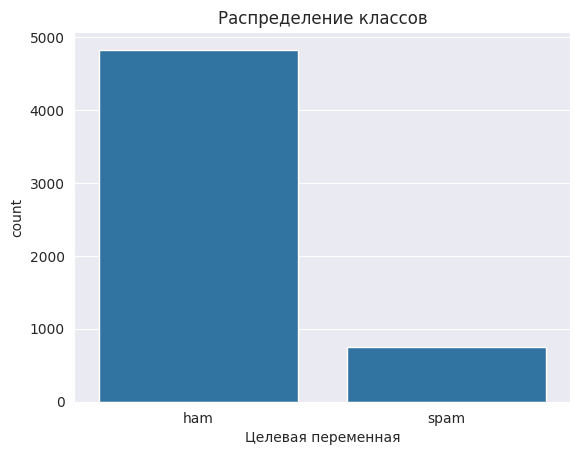

In [187]:
print(df.info())
print('Размерность датафрейма', '-'*31, df.shape, '='*31, sep='\n')
print('Количество пропущенных значений','-'*31, df.isnull().sum(), '='*31, sep='\n')
print('Распределение классов', '-'*31, df['v1'].value_counts(), '='*31, sep='\n' )
sns.countplot(x=df['v1'])
plt.title('Распределение классов')
plt.xlabel('Целевая переменная')
plt.show()

In [188]:
df = df.drop_duplicates()
print(df.loc[~df['Unnamed: 2'].isnull(), 'Unnamed: 2'].count())
print(df.loc[~df['Unnamed: 3'].isnull(), 'Unnamed: 3'].count())
print(df.loc[~df['Unnamed: 4'].isnull(), 'Unnamed: 4'].count())

43
10
5


# 3 Предобработка данных

In [239]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AI_my_project/spam_NB_model/spam.csv', encoding = 'ISO-8859-1')

def combine_columns(row):
    combined = ' '.join(str(row[col]) for col in ['v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'])
    return combined

df.fillna('', inplace=True)
df['v2'] = df.apply(combine_columns, axis=1)
df = df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'])

df.columns = ['target', 'text']

df.text = df.text.astype(str)

df.text = df.text.str.lower()
df.text = df.text.str.strip()
df.text = df.text.fillna('')
df.text = df.text.str.translate(str.maketrans('', '', string.punctuation))

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
df.text = df.text.apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

df.target = df.target.replace({'ham': 0, 'spam': 1})
df=df[df.text.str.strip() != '']

df.to_csv('/content/drive/MyDrive/Colab Notebooks/AI_my_project/spam_NB_model/spam_clear.csv', index=None)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
<ipython-input-239-0c467733ba26>:24: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.target = df.target.replace({'ham': 0, 'spam': 1})


In [240]:
print(df.text.isna().sum())
print(df.target.isna().sum())
print(df.text.apply(type).value_counts())
print(df[df.text.str.strip() == ''].shape[0])
df.head(10)

0
0
text
<class 'str'>    5567
Name: count, dtype: int64
0


,target,text
0,0,go jurong point crazy available bugis n great ...
1,0,ok lar joking wif u oni
2,1,free entry 2 wkly comp win fa cup final tkts 2...
3,0,u dun say early hor u c already say
4,0,nah dont think goes usf lives around though
5,1,freemsg hey darling 3 weeks word back id like ...
6,0,even brother like speak treat like aids patent
7,0,per request melle melle oru minnaminunginte nu...
8,1,winner valued network customer selected receiv...
9,1,mobile 11 months u r entitled update latest co...


# 4 Обучение Наивной байесовской модели

In [266]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AI_my_project/spam_NB_model/spam_clear.csv')

feature_train, feature_test, label_train, label_test = train_test_split(df.text, df.target, test_size=0.2, random_state=52)

pipeline = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('classifier', MultinomialNB())
])

model = pipeline.fit(feature_train, label_train)
model

Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('classifier', MultinomialNB())])

#5 Исследование результатов

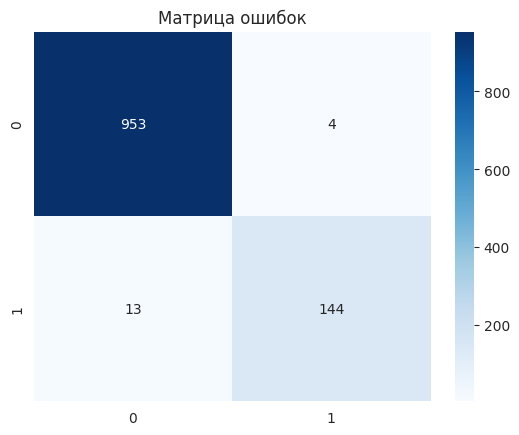

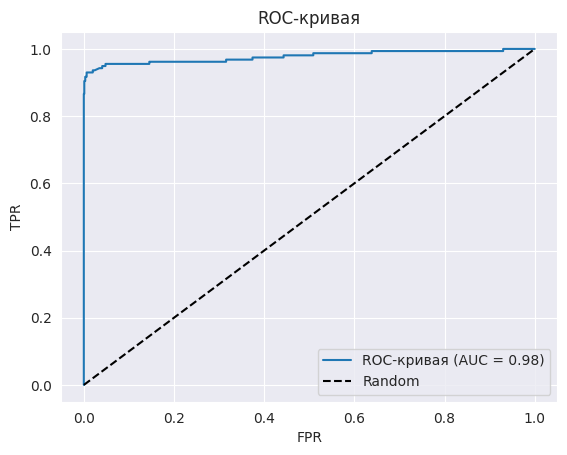


Точность модели на обучающей выборке: 0.9948349427352347

Точность модели на тестовой выборке: 0.9847396768402155

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       957
           1       0.97      0.92      0.94       157

    accuracy                           0.98      1114
   macro avg       0.98      0.96      0.97      1114
weighted avg       0.98      0.98      0.98      1114



In [270]:
pred_train = pipeline.predict(feature_train)
pred_test = pipeline.predict(feature_test)

conf_matrix = confusion_matrix(label_test, pred_test)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Матрица ошибок')
plt.show()
y_pred_proba = pipeline.predict_proba(feature_test)[:, 1]

fpr, tpr, thresholds = roc_curve(label_test, y_pred_proba)
auc_score = roc_auc_score(label_test, y_pred_proba)
print()
plt.plot(fpr, tpr, label=f'ROC-кривая (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC-кривая')
plt.legend()
plt.show()
print()
print(f'Точность модели на обучающей выборке: {accuracy_score(label_train, pred_train)}')
print()
print(f'Точность модели на тестовой выборке: {accuracy_score(label_test, pred_test)}')
print()
print(classification_report(label_test, pred_test))

# Анализ и выводы

#### 1. **Предобработка данных**
   - Исходный датафрейм содержал 5572 записи и 5 колонок. Колонки `Unnamed: 2`, `Unnamed: 3` и `Unnamed: 4` содержали значительное количество пропущенных значений (5522, 5560 и 5566 соответственно). Для устранения пропусков все значения `NaN` были заменены на пустые строки.
   - Текстовые данные из колонок `v2`, `Unnamed: 2`, `Unnamed: 3` и `Unnamed: 4` были объединены в одну колонку `text`. Это позволило сохранить всю доступную текстовую информацию.
   - Текст был приведен к нижнему регистру, удалены пунктуация и стоп-слова (использовался список стоп-слов из библиотеки `nltk`).
   - Метки классов (`ham` и `spam`) были преобразованы в числовой формат: `ham` → `0`, `spam` → `1`.

#### 2. **Обучение модели**
   - Для классификации текстовых данных был использован пайплайн, состоящий из двух этапов:
     1. **Векторизация текста**: С помощью `CountVectorizer` текстовые данные были преобразованы в числовой формат (мешок слов).
     2. **Классификация**: Использовался наивный байесовский классификатор (`MultinomialNB`).

#### 3. **Оценка модели**
   - Точность модели на обучающей выборке составила **99.48%**, а на тестовой — **98.47%**. Это указывает на то, что модель хорошо обобщает данные и не переобучена.
   - Для класса 0 (ham):

  - Precision: 0.99

  - Recall: 1.00

  - F1-score: 0.99

- Для класса 1 (spam):

  - Precision: 0.97

  - Recall: 0.92

  - F1-score: 0.94

- Общая точность модели (accuracy) составила 98.47%.
- Метрики macro avg и weighted avg также находятся на высоком уровне (0.97 и 0.98 соответственно), что подтверждает сбалансированность модели.

Модель демонстрирует высокую точность как на обучающей, так и на тестовой выборках. Это свидетельствует о том, что модель хорошо справляется с задачей классификации писем на спам и хам.

Высокие значения метрик precision, recall и F1-score для обоих классов указывают на то, что модель эффективно идентифицирует как спам, так и хам.

Небольшое снижение точности на тестовой выборке (по сравнению с обучающей) является нормальным явлением и не указывает на переобучение.